In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Alzemier-Dataset.zip"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, rotation_range=10,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                   target_size = (224,224), class_mode = 'categorical',
                                                   subset = 'training', batch_size = 32)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                  target_size = (224,224), class_mode = 'categorical',
                                                  subset = 'validation', batch_size = 32)

Found 1023 images belonging to 4 classes.


In [7]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                  target_size = (224,224), class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [8]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]

In [9]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# CNN

In [10]:
def build_model():
    
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),padding='same',input_shape = (224,224,3),activation='relu'))
    
    model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
    
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dense(32))
    model.add(Dense(32))
    model.add(Dense(32))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',metrics=METRICS)

In [12]:
history=model.fit(train_dataset, validation_data=valid_dataset, epochs = 10,
                  verbose = 1, callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 73s 477ms/step - loss: 6.4128 - accuracy: 0.7504 - val_loss: 1.0411 - val_accuracy: 0.7502 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 60s 460ms/step - loss: 1.0430 - accuracy: 0.7488 - val_loss: 1.0367 - val_accuracy: 0.7502 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 60s 467ms/step - loss: 1.0414 - accuracy: 0.7488 - val_loss: 1.0528 - val_accuracy: 0.7500 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 60s 465ms/step - loss: 1.0391 - accuracy: 0.7487 - val_loss: 1.0350 - val_accuracy: 0.7500 - lr: 0.0025
Epoch 5/10
129/129 [==============================] - 59s 454ms/step - loss: 1.0380 - accuracy: 0.7488 - val_loss: 1.0343 - val_accuracy: 0.7502 - lr: 0.0016
Epoch 6/10
129/129 [==============================] - 59s 454ms/step - loss: 1.0378 - accuracy: 0.7490 - val_loss: 1.0370 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/10
129/129 [==============================] 

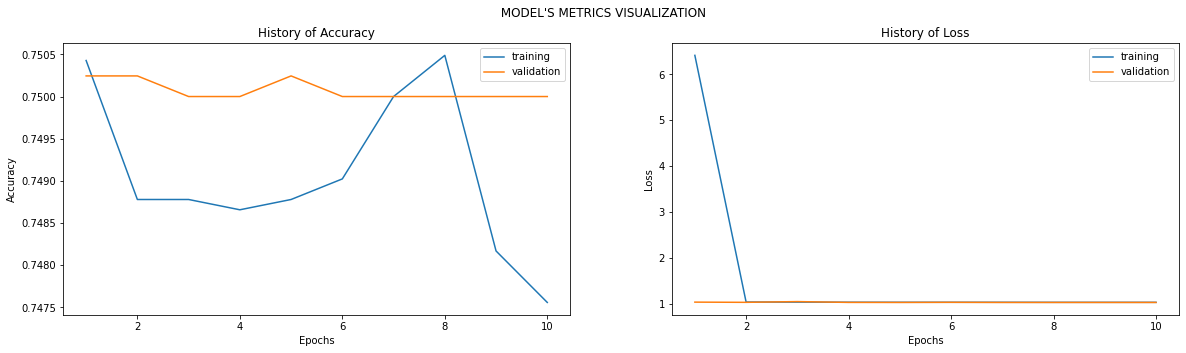

In [13]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [14]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [15]:
print("Loss = ", scores[0])
print("Accuracy = ", scores[1])

Loss =  1.0330488681793213
Accuracy =  0.75


In [16]:
metrics_lis = []
metrics_lis.append(["CNN", scores[0], scores[1]])

# ResNet

In [17]:
base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable=False

In [19]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                      

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [21]:
history=model.fit(train_dataset, validation_data=valid_dataset, epochs = 10, verbose = 1, callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 75s 519ms/step - loss: 1.0953 - accuracy: 0.7468 - val_loss: 1.0973 - val_accuracy: 0.7297 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 65s 502ms/step - loss: 1.0465 - accuracy: 0.7588 - val_loss: 1.0566 - val_accuracy: 0.7644 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 66s 512ms/step - loss: 1.0330 - accuracy: 0.7604 - val_loss: 1.0591 - val_accuracy: 0.7696 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 65s 499ms/step - loss: 1.0271 - accuracy: 0.7672 - val_loss: 1.0452 - val_accuracy: 0.7703 - lr: 0.0025
Epoch 5/10
129/129 [==============================] - 65s 500ms/step - loss: 1.0207 - accuracy: 0.7682 - val_loss: 1.0356 - val_accuracy: 0.7722 - lr: 0.0016
Epoch 6/10
129/129 [==============================] - 64s 496ms/step - loss: 1.0274 - accuracy: 0.7704 - val_loss: 1.0373 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 7/10
129/129 [==============================] 

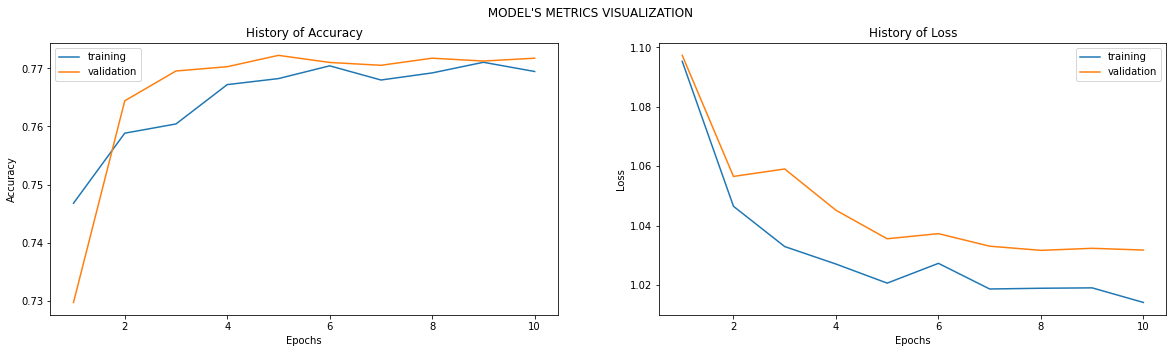

In [22]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [23]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [24]:
print("Loss = ", scores[0])
print("Accuracy = ", scores[1])

Loss =  1.0042762756347656
Accuracy =  0.7797107100486755


In [25]:
metrics_lis.append(["ResNet", scores[0], scores[1]])

# VGG16

In [26]:
base_model = VGG16(input_shape=(224,224,3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [27]:
for layer in base_model.layers:
    layer.trainable=False

In [28]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_6 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 2048)              51382272  
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [29]:
model.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer="rmsprop")

In [30]:
history=model.fit(train_dataset, validation_data=valid_dataset, epochs = 10, verbose = 1, callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 82s 588ms/step - loss: 2.0744 - accuracy: 0.7391 - val_loss: 2.0485 - val_accuracy: 0.7502 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 71s 552ms/step - loss: 1.1596 - accuracy: 0.7651 - val_loss: 1.0762 - val_accuracy: 0.7561 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 71s 548ms/step - loss: 1.0439 - accuracy: 0.7771 - val_loss: 1.0068 - val_accuracy: 0.7837 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 72s 554ms/step - loss: 0.9932 - accuracy: 0.7866 - val_loss: 0.9884 - val_accuracy: 0.7823 - lr: 0.0025
Epoch 5/10
129/129 [==============================] - 71s 549ms/step - loss: 0.9782 - accuracy: 0.7929 - val_loss: 1.0097 - val_accuracy: 0.7715 - lr: 0.0016
Epoch 6/10
129/129 [==============================] - 71s 548ms/step - loss: 0.9652 - accuracy: 0.7930 - val_loss: 1.0129 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 7/10
129/129 [==============================] 

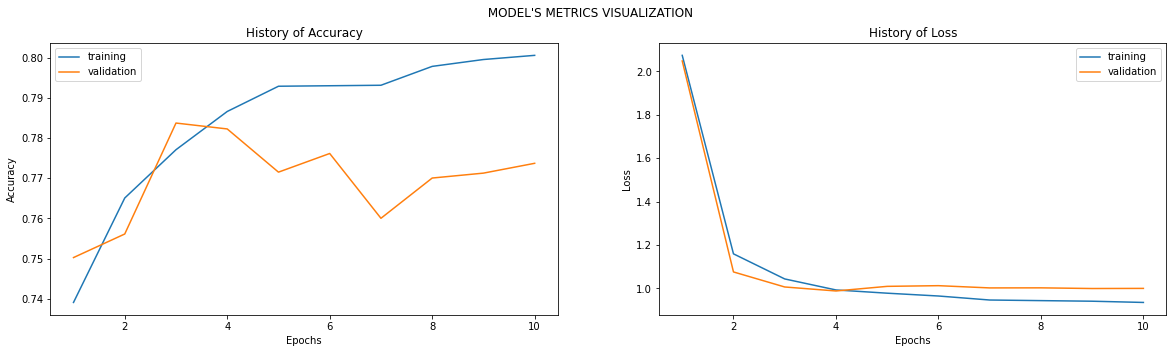

In [31]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [32]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [33]:
print("Loss = ", scores[0])
print("Accuracy = ", scores[1])

Loss =  0.942965030670166
Accuracy =  0.7912431359291077


In [34]:
metrics_lis.append(["VGG16", scores[0], scores[1]])

# InceptionV3

In [35]:
base_model = InceptionV3(input_shape=(224,224,3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 1s 0us/step


In [36]:
for layer in base_model.layers:
    layer.trainable=False

In [37]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_8 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_103 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_14 (Dense)            (None, 64)               

In [38]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [39]:
history=model.fit(train_dataset, validation_data=valid_dataset, epochs = 10, verbose = 1, callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 71s 483ms/step - loss: 1.0593 - accuracy: 0.7707 - val_loss: 1.0113 - val_accuracy: 0.7896 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 60s 461ms/step - loss: 0.9954 - accuracy: 0.7817 - val_loss: 1.0344 - val_accuracy: 0.7739 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 59s 459ms/step - loss: 0.9717 - accuracy: 0.7884 - val_loss: 1.0057 - val_accuracy: 0.7825 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 59s 457ms/step - loss: 0.9677 - accuracy: 0.7875 - val_loss: 1.0181 - val_accuracy: 0.7781 - lr: 0.0025
Epoch 5/10
129/129 [==============================] - 59s 453ms/step - loss: 0.9595 - accuracy: 0.7879 - val_loss: 1.0149 - val_accuracy: 0.7793 - lr: 0.0016
Epoch 6/10
129/129 [==============================] - 59s 458ms/step - loss: 0.9484 - accuracy: 0.7909 - val_loss: 1.0218 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 7/10
129/129 [==============================] 

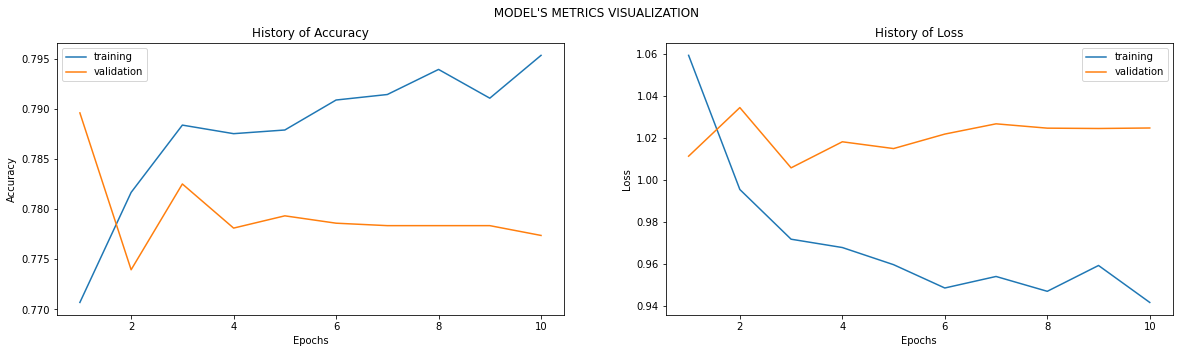

In [40]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [41]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [42]:
print("Loss = ", scores[0])
print("Accuracy = ", scores[1])

Loss =  1.0125575065612793
Accuracy =  0.7742376923561096


In [43]:
metrics_lis.append(["InceptionV3", scores[0], scores[1]])

# InceptionResNetV2

In [44]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")

219070464/219055592 [==============================] - 2s 0us/step


In [45]:
for layer in base_model.layers:
    layer.trainable=False

In [46]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 5, 5, 1536)        0         
                                                                 
 flatten_4 (Flatten)         (None, 38400)             0         
                                                                 
 batch_normalization_312 (Ba  (None, 38400)            153600    
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            (None, 32)                1228832   
                                                                 
 batch_normalization_313 (Ba  (None, 32)              

In [47]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [48]:
history=model.fit(train_dataset, validation_data=valid_dataset, epochs = 10, verbose = 1, callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 100s 657ms/step - loss: 1.0901 - accuracy: 0.7567 - val_loss: 1.0173 - val_accuracy: 0.7901 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 81s 627ms/step - loss: 1.0246 - accuracy: 0.7678 - val_loss: 1.0373 - val_accuracy: 0.7869 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 80s 616ms/step - loss: 1.0038 - accuracy: 0.7762 - val_loss: 0.9981 - val_accuracy: 0.7752 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 80s 620ms/step - loss: 1.0006 - accuracy: 0.7798 - val_loss: 0.9982 - val_accuracy: 0.7727 - lr: 0.0025
Epoch 5/10
129/129 [==============================] - 81s 623ms/step - loss: 0.9905 - accuracy: 0.7790 - val_loss: 0.9952 - val_accuracy: 0.7766 - lr: 0.0016
Epoch 6/10
129/129 [==============================] - 80s 621ms/step - loss: 0.9834 - accuracy: 0.7814 - val_loss: 1.0026 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 7/10
129/129 [==============================]

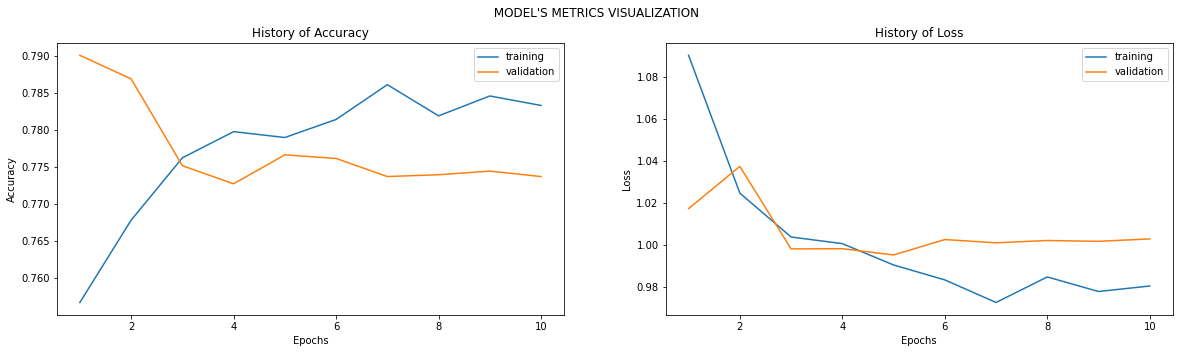

In [49]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [50]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [51]:
print("Loss = ", scores[0])
print("Accuracy = ", scores[1])

Loss =  0.9708396792411804
Accuracy =  0.7853792309761047


In [52]:
metrics_lis.append(["InceptionResNetV2", scores[0], scores[1]])

In [53]:
df =  pd.DataFrame(metrics_lis)
df.rename(columns={0:"Model", 1: "Loss", 2: "Accuracy"}, inplace = True)
from IPython.display import HTML
HTML(df.to_html(index=False),)

Model,Loss,Accuracy
CNN,1.033049,0.750000
ResNet,1.004276,0.779711
VGG16,0.942965,0.791243
InceptionV3,1.012558,0.774238
InceptionResNetV2,0.970840,0.785379
